# Introdução:
Temos um conjunto de dados de vendas de veículos usados e, em posse disso, vamos:

1 - Fazer um levantamento de quais estatísticas nos são mais relevantes;

2 - Fazer uma análise exploratória de dados e criar e responder 3 perguntas de negócio, e também responder as seguintes perguntas:

   2.a - Qual o melhor estado na base de dados para se vender um veículo e por que? 
   
   2.b - Qual o melhor estado para se comprar uma Picape com transmissão automática e por que?
   
   2.c - Qual o melhor estado para se comprar carros que estejam dentro da garantia de fábrica e por que?
    
3 - como será feita a previsão do preço e por que? qual tipo de problema estamos resolvendo? qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por que?

## Bibliotecas:

Abaixo, importamos todas as bibliotecas que serão usadas ao longo deste projeto.

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

sns.set()

## Funções:

In [2]:
def double_bar_plot(series1,
                    series2,
                    figsize=(12,6),
                    xlabel1=None,
                    xlabel2=None,
                    ylabel1=None,
                    ylabel2=None,
                    title1=None,
                    title2=None,
                   color1='mediumaquamarine',
                   color2='sandybrown'):
    plt.figure(figsize=figsize, facecolor='moccasin')

    plt.subplot(1,2,1)
    sns.barplot(x=series1.index, y=series1, color=color1, alpha=0.7);
    plt.xlabel(xlabel1)
    plt.ylabel(ylabel1)
    plt.title(title1)
    plt.xticks(rotation=64)

    plt.subplot(1, 2, 2)
    sns.barplot(x=series2.index, y=series2, color=color2, alpha=0.7);
    plt.xlabel(xlabel2)
    plt.ylabel(ylabel2)
    plt.title(title2)
    plt.xticks(rotation=64)

    plt.show()

## Dados:
Temos um conjunto de treino e um conjunto de teste já previamente separados. Aqui, carregamos ambos. Os dados foram recebidos em arquivos .csv que estavam codificados em UTF-16LE, e as colunas estavam separadas pelo caracter de espaçamento `\t`. 

Além de carregar os dados, vamos tentar extrair algumas informações preliminares: quais features estão envolvidas, qual o tipo de cada feature e algumas estatísticas básicas de features numéricas.

In [3]:
treino = pd.read_csv("cars_train.csv", delimiter='\t', encoding='utf-16-le')
teste  = pd.read_csv("cars_test.csv",  delimiter='\t', encoding='utf-16-le')

# quantidade de dados e features com os quais estamos trabalhando:
print("treino:", treino.shape)
print("teste:", teste.shape)
print()

# Todas as features com as quais estamos lidando: 
print("features: ")
treino.info()

treino: (29584, 29)
teste: (9862, 28)

features: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29584 entries, 0 to 29583
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       29584 non-null  object 
 1   num_fotos                29407 non-null  float64
 2   marca                    29584 non-null  object 
 3   modelo                   29584 non-null  object 
 4   versao                   29584 non-null  object 
 5   ano_de_fabricacao        29584 non-null  int64  
 6   ano_modelo               29584 non-null  float64
 7   hodometro                29584 non-null  float64
 8   cambio                   29584 non-null  object 
 9   num_portas               29584 non-null  int64  
 10  tipo                     29584 non-null  object 
 11  blindado                 29584 non-null  object 
 12  cor                      29584 non-null  object 
 13  tipo_vendedor            2

In [4]:
treino.describe()

,num_fotos,ano_de_fabricacao,ano_modelo,hodometro,num_portas,veiculo_alienado,preco
count,29407.000000,29584.000000,29584.000000,29584.000000,29584.000000,0.0,2.958400e+04
mean,10.323834,2016.758552,2017.808985,58430.592077,3.940677,NaN,1.330239e+05
std,3.487334,4.062422,2.673930,32561.769309,0.338360,NaN,8.166287e+04
min,8.000000,1985.000000,1997.000000,100.000000,2.000000,NaN,9.869951e+03
25%,8.000000,2015.000000,2016.000000,31214.000000,4.000000,NaN,7.657177e+04
50%,8.000000,2018.000000,2018.000000,57434.000000,4.000000,NaN,1.143558e+05
75%,14.000000,2019.000000,2020.000000,81953.500000,4.000000,NaN,1.636796e+05
max,21.000000,2022.000000,2023.000000,390065.000000,4.000000,NaN,1.359813e+06


Pudemos ver acima pelas contagens que faltam valores de algumas features. Em outras palavras, há dados nulos em nosso conjunto de dados. Vamos procurar entender melhor estes dados nulos para decidirmos se vamos tratá-los, preenchê-los ou mesmo descartá-los:

In [5]:
# dados nulos em teste: 
dados_nulos = (teste.isnull().sum()[teste.isnull().sum() > 0])
print("dados nulos em teste:")
print(dados_nulos)

print()

# dados nulos em treino: 
dados_nulos = (treino.isnull().sum()[treino.isnull().sum() > 0])
print("dados nulos em treino: ")
print(dados_nulos)

dados nulos em teste:
num_fotos                    60
dono_aceita_troca          2554
veiculo_único_dono         6387
revisoes_concessionaria    6795
ipva_pago                  3298
veiculo_licenciado         4518
garantia_de_fábrica        8439
revisoes_dentro_agenda     7869
veiculo_alienado           9862
dtype: int64

dados nulos em treino: 
num_fotos                    177
dono_aceita_troca           7662
veiculo_único_dono         19161
revisoes_concessionaria    20412
ipva_pago                   9925
veiculo_licenciado         13678
garantia_de_fábrica        25219
revisoes_dentro_agenda     23674
veiculo_alienado           29584
dtype: int64


Vamos investigar isso melhor. Abaixo, algumas coisas chamam a atenção. 

A coluna `'veiculo_alienado'` possui apenas dados nulos. Isso pode querer dizer que nenhum veículo da base de dados é alieanado, mas, de todo modo, o dado é uma constante e portanto trivial. Descartaremos esta coluna.

A coluna `'num_fotos'` possui relativamente poucos dados nulos. Substituíremos esses dados nulos pela parte inteira da média de fotos por veículo considerando todo o conjunto de dados(treino e teste). Parece fazer mais sentido substituir por um valor médio do que por 0 pois parece improvável que se anuncie um veículo à venda na internet sem que haja fotos do veículo.

Como se pode ver abaixo, todas as outras possuem apenas dois valores. Não há como distinguir se há dados ausentes nessas colunas ou não pois, ao que parece, os dados ausentes se confundiriam com dados negativos. Por exemplo, não temos como saber se um veículo não está licenciado de fato ou se a informação apenas está ausente. Optamos, em um primeiro momento, por supor que não há dados ausentes nestas colunas e subsituímos seus valores por `True` ou `False`. 

In [6]:
for coluna in dados_nulos.index:
    print("{}(teste):\n".format(coluna), teste[coluna].unique())
    print("{}(treino):\n".format(coluna), treino[coluna].unique())
    print()

num_fotos(teste):
 [ 8. 18. 16. 17. 15. 14. 13. 12.  9. 20. nan 11. 19. 21.]
num_fotos(treino):
 [ 8. 16. 14. 13. 15. 20. 11.  9. 18. 17. 12. nan 19. 21. 10.]

dono_aceita_troca(teste):
 ['Aceita troca' nan]
dono_aceita_troca(treino):
 [nan 'Aceita troca']

veiculo_único_dono(teste):
 [nan 'Único dono']
veiculo_único_dono(treino):
 [nan 'Único dono']

revisoes_concessionaria(teste):
 [nan 'Todas as revisões feitas pela concessionária']
revisoes_concessionaria(treino):
 ['Todas as revisões feitas pela concessionária' nan]

ipva_pago(teste):
 ['IPVA pago' nan]
ipva_pago(treino):
 ['IPVA pago' nan]

veiculo_licenciado(teste):
 ['Licenciado' nan]
veiculo_licenciado(treino):
 ['Licenciado' nan]

garantia_de_fábrica(teste):
 ['Garantia de fábrica' nan]
garantia_de_fábrica(treino):
 [nan 'Garantia de fábrica']

revisoes_dentro_agenda(teste):
 [nan 'Todas as revisões feitas pela agenda do carro']
revisoes_dentro_agenda(treino):
 [nan 'Todas as revisões feitas pela agenda do carro']

veiculo_al

In [7]:
# media de numero de fotos por anúncio
(teste['num_fotos'].sum()+treino['num_fotos'].sum())/(treino.shape[0]+teste.shape[0])

10.2618009430614

In [8]:
# descarta a coluna 'veiculo_alienado':
treino.drop(columns='veiculo_alienado', inplace=True)
teste.drop(columns='veiculo_alienado', inplace=True)

# transforma os dados das demais colunas com dados nulos,
# com exceção de 'num_fotos' e 'veiculo_alienado':
for coluna in dados_nulos.index[1:-1]:
    treino[coluna] = treino[coluna].apply(lambda x: (type(x) == str))
    teste[coluna]  =  teste[coluna].apply(lambda x: (type(x) == str))    
    
# substitui dados nulos em fotos por um valor próximo à média: 
treino['num_fotos'].fillna(10, inplace=True)
teste['num_fotos'].fillna(10, inplace=True)

Agora, como podemos ver, já não há mais dados nulos nos conjuntos de teste e treino.

In [9]:
# dados nulos em teste: 
dados_nulos = (teste.isnull().sum()[teste.isnull().sum() > 0])
print("dados nulos em teste:")
print(dados_nulos)

print()

# dados nulos em treino: 
dados_nulos = (treino.isnull().sum()[treino.isnull().sum() > 0])
print("dados nulos em treino: ")
print(dados_nulos)

dados nulos em teste:
Series([], dtype: int64)

dados nulos em treino: 
Series([], dtype: int64)


Agora, vamos renomear algumas colunas para facilitar a manipulação dos dados. 

In [10]:
print("antes:\n", treino.columns)

nomes = {'num_fotos'           : 'fotos', 
         'ano_de_fabricacao'   : 'fabricacao',
         'num_portas'          : 'portas',
         'entrega_delivery'    : 'delivery',
         'dono_aceita_troca'   : 'aceita_troca',
         'veiculo_único_dono'  : 'unico_dono',
         'garantia_de_fábrica' : 'garantia',
         'veiculo_licenciado'  : 'licenciado',
         'estado_vendedor'     : 'uf'
        }
teste.rename(columns=nomes, inplace=True)
treino.rename(columns=nomes, inplace=True)
print()
print("depois:\n", treino.columns)

antes:
 Index(['id', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'hodometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'anunciante', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'dono_aceita_troca', 'veiculo_único_dono', 'revisoes_concessionaria',
       'ipva_pago', 'veiculo_licenciado', 'garantia_de_fábrica',
       'revisoes_dentro_agenda', 'preco'],
      dtype='object')

depois:
 Index(['id', 'fotos', 'marca', 'modelo', 'versao', 'fabricacao', 'ano_modelo',
       'hodometro', 'cambio', 'portas', 'tipo', 'blindado', 'cor',
       'tipo_vendedor', 'cidade_vendedor', 'uf', 'anunciante', 'delivery',
       'troca', 'elegivel_revisao', 'aceita_troca', 'unico_dono',
       'revisoes_concessionaria', 'ipva_pago', 'licenciado', 'garantia',
       'revisoes_dentro_agenda', 'preco'],
      dtype='object')


Vamos também dar uma forma mais conveniente à coluna com dados dos estados dos vendedores. Podemos observar que não há, dentre os dados de treino, vendedores no Distrito Federal(DF) e no Amapá(AP), e dentre os dados de teste, além deste já citados, não há vendedores do Maranhão (MA).  

In [11]:
treino['uf'] = treino['uf'].apply(lambda x: x[-3:-1])
teste['uf'] = teste['uf'].apply(lambda x: x[-3:-1])

print("quantidade de estados (treino):", len(treino['uf'].unique()))
print(treino['uf'].unique())
print()
print("quantidade de estados (teste):", len(teste['uf'].unique()))
print(teste['uf'].unique())

quantidade de estados (treino): 25
['SP' 'MG' 'RJ' 'SC' 'RS' 'RN' 'PA' 'GO' 'PR' 'BA' 'PE' 'TO' 'AL' 'PB'
 'MS' 'AM' 'MT' 'MA' 'AC' 'CE' 'SE' 'RR' 'ES' 'PI' 'RO']

quantidade de estados (teste): 24
['SP' 'AM' 'GO' 'RS' 'SC' 'PR' 'RJ' 'PE' 'RN' 'PA' 'MG' 'MT' 'BA' 'AL'
 'CE' 'TO' 'PB' 'ES' 'SE' 'MS' 'AC' 'PI' 'RO' 'RR']


Abaixo, podemos ver que São Paulo é o estado onde mais tem veículos anunciados. Isso não deveria ser surpreendente, porque São Paulo é o estado com maior poder econômico do Brasil, segunda maior renda per capita, e também a maior população. Roraima, por outro lado, é o estado com menor poder econômico e menor população, o que pode justificar sua baixa quantidade de anúncios nestes dados. 

Entretanto, esses dados não necessariamente refletem o cenário nacional como um todo, pois não sabemos a origem dos dados. Por exemplo, os dados podem ter vindo de uma plataforma que investe mais em marketing no estado de São Paulo do que nos outros. O Distrito Federal tem a maior renda per capita e a maior densidade demográfica do País, contando com mais de quatro vezes a população de Roraima, mas sequer consta no conjunto de dados com o qual trabalhamos. 

Dito isso, não podemos usar apenas esses dados para falar de compra e vendas a um nível verdadeiramente nacional. 

Abaixo, podemos ver que há muito mais anúncios em SP do que nos demais estados:


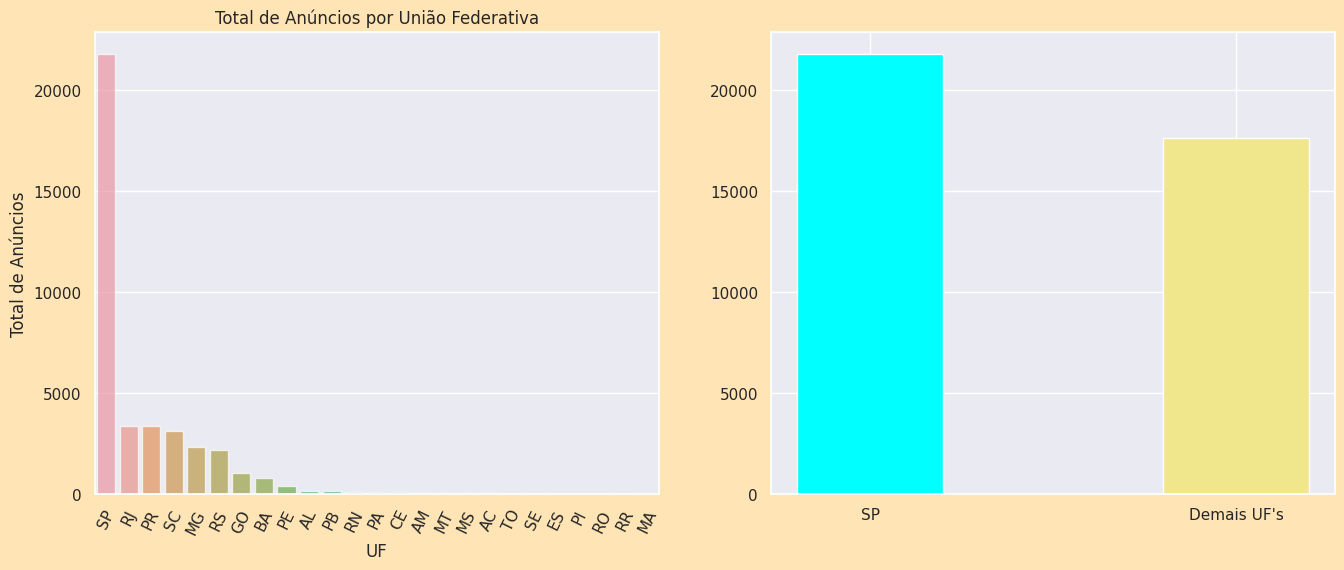

In [12]:
x1 = treino['uf'].value_counts() + teste['uf'].value_counts()
x1.sort_values(ascending=False, inplace=True)

plt.figure(figsize = (16,6), facecolor='moccasin')

plt.subplot(1, 2, 1)
plt.title('Total de Anúncios por União Federativa')
sns.barplot(x=x1.index, y=x1.values, alpha=0.7, label='treino')
plt.xlabel('UF')
plt.ylabel('Total de Anúncios')
plt.xticks(rotation=64)

sp = treino[treino['uf'] == 'SP']['uf'].value_counts().sum() + teste[teste['uf'] == 'SP']['uf'].value_counts().sum()    
demais = treino[treino['uf'] != 'SP']['uf'].value_counts().sum() + teste[teste['uf'] != 'SP']['uf'].value_counts().sum()
plt.subplot(1, 2, 2)
plt.bar(['SP', "Demais UF's"], [sp, demais], color =['cyan', 'khaki'],width = 0.4)

plt.show()

# Melhor estado para se vender carros de marcas populares
Primeiro, precisamos definir o que são marcas populares. A expressão "carro popular" costuma se referir a "carros de entrada", carros mais baratos do que média. Vamos primeiro olhar para a média de preços dos carros anunciados: 

In [13]:
preco_medio = treino['preco'].mean()
print("preço médio:",preco_medio)

preço médio: 133023.87988039522


Vemos que a média de preços dos veículos anunciados está por volta de 133 mil reais. Vamos agora olhar para a média dos preços dos veículos por marca:

In [14]:
medias_marcas = (treino.groupby('marca')['preco'].mean().sort_values())
medias_marcas

marca
EFFA              40163.175829
BRM               47762.671073
CHRYSLER          62569.784569
ALFA ROMEO        68172.543195
CITROËN           73494.483671
DODGE             74370.666721
RENAULT           82649.368865
LIFAN             84161.746098
HYUNDAI           84419.639625
SSANGYONG         84982.203734
SMART             91242.896761
SUZUKI            92604.776444
CHEVROLET         93187.683964
JAC               94387.618711
FIAT              99711.164582
HONDA            100620.715073
NISSAN           109275.319281
FERRARI          114439.236279
VOLKSWAGEN       117940.087380
CHERY            121716.542250
PEUGEOT          122797.835086
KIA              123252.810780
FORD             127453.062261
SUBARU           138272.951868
JEEP             138367.166001
MITSUBISHI       142199.287880
MINI             146232.484657
TROLLER          148570.646834
IVECO            151197.557227
TOYOTA           156195.160143
AUDI             159977.750342
MERCEDES-BENZ    176870.776900
LE

Vamos considerar 'marcas populares' como sendo marcas cuja média dos preços está abaixo do preço médio calculado acima: 

In [15]:
marcas_populares = medias_marcas.loc[lambda x: x<preco_medio].index
marcas_populares = treino[treino['marca'].isin(marcas_populares)]

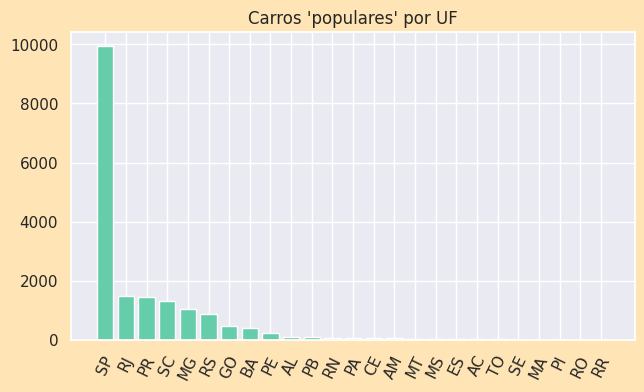

In [16]:
populares = marcas_populares['uf'].value_counts()

plt.figure(figsize = (16,4), facecolor='moccasin')

plt.subplot(1, 2, 1)
plt.bar(populares.index,populares, color='mediumaquamarine');
plt.title("Carros 'populares' por UF")
plt.xticks(rotation=64)
plt.show()

Vamos agora olhar para a média de preços de marcas populares por UF: 

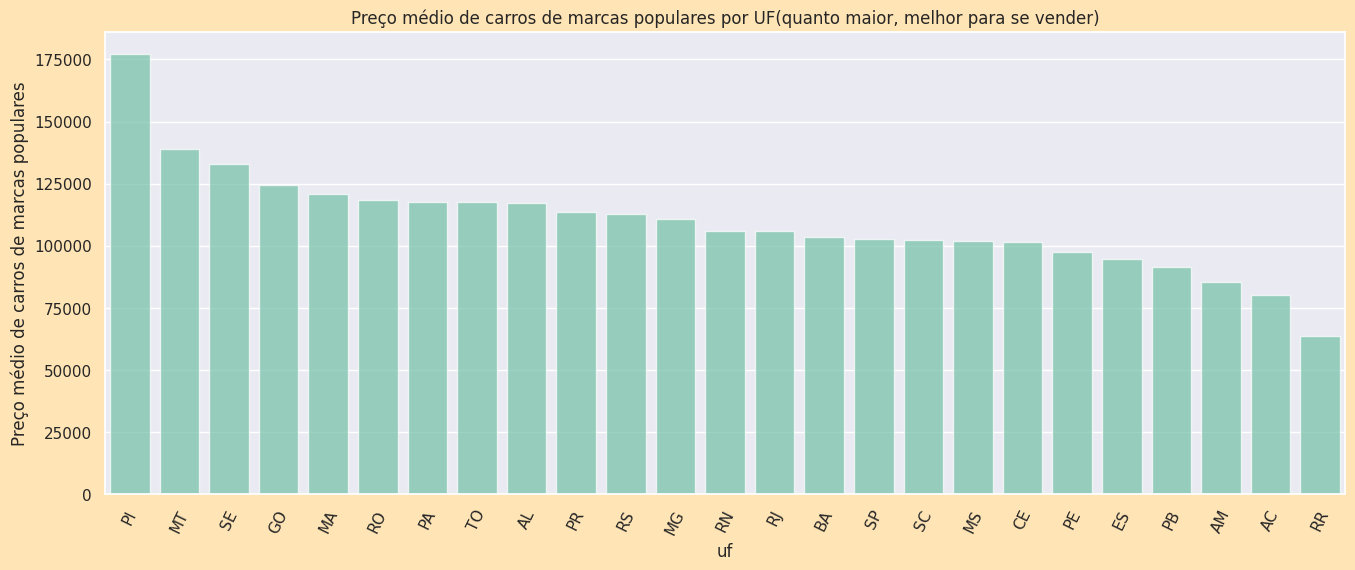

In [17]:
populares_medias_uf = marcas_populares.groupby('uf')['preco'].mean().sort_values(ascending=False)

plt.figure(figsize = (16,6), facecolor='moccasin')
sns.barplot(x=populares_medias_uf.index, y=populares_medias_uf, color='mediumaquamarine', alpha=0.7, label='treino');
plt.ylabel('Preço médio de carros de marcas populares')
plt.title('Preço médio de carros de marcas populares por UF(quanto maior, melhor para se vender)')
plt.xticks(rotation=64)
plt.show()

Aqui já nos parece que Piauí é a melhor opção para se vender carros de marcas populares(conforme nossa definição de marcas populares), pois é o estado onde a média dos preços de carros dessas marcas é maior. 

Agora, a fim de ver a variabilidade dos preços dos veículos das marcas populares por UF, vamos olhar para o desvio padrão dos preços de carros de marcas populares nesses estados que tem a média mais alta:

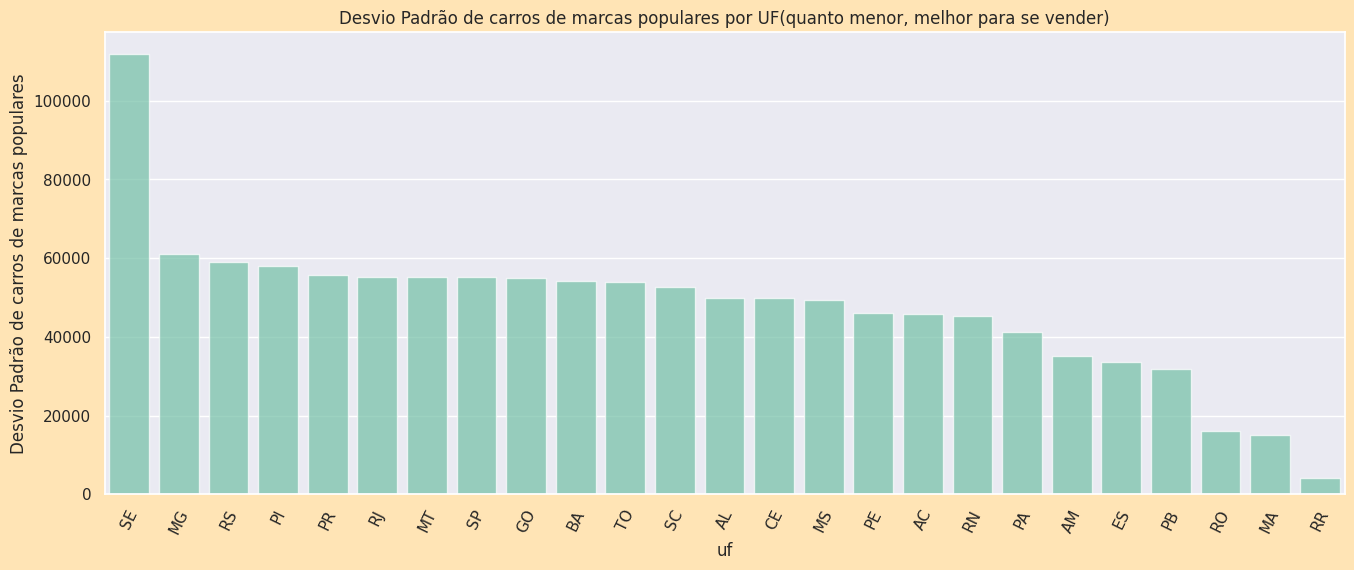

In [18]:
populares_desvios_uf = marcas_populares.groupby('uf')['preco'].std().sort_values(ascending=False)

plt.figure(figsize = (16,6), facecolor='moccasin')
sns.barplot(x=populares_desvios_uf.index, y=populares_desvios_uf, color='mediumaquamarine', alpha=0.7, label='treino');
plt.ylabel('Desvio Padrão de carros de marcas populares')
plt.title('Desvio Padrão de carros de marcas populares por UF(quanto menor, melhor para se vender)')
plt.xticks(rotation=64)
plt.show()

Uma média alta nos diz que é bom vender veículos em um estado porque pode ser mais fácil de se competir no mercado local. Um desvio padrão baixo nos diz que o preço dos carros varia pouco. Se tivermos uma média alta e um desvio padrão baixo, significa que temos preços altos e poucas opções de preços. Vemos que Maranhão e Rondônia tem preço médio de veículos de marcas populares bastante altos, embora não tanto quanto Piauí, mas em compensação tem Desvio Padrão bem mais baixo. 

Para decidir, agora vamos olhar para o Coeficiente de Variação, que é a razão entre o Desvio Padrão e a Média. Nós procuramos aqui o Coeficiente de Variação mais baixo pois, além de nos dizer qual estado apresenta menor variabilidade de dados em relação à média (o que seria bom para vendas), por ser a razão entre o Desvio Padrão e a Média, pode ser, neste caso, encarado como uma relação de "custo/benefício" entre essas duas medidas, pois queremos maximizar a média, o que contribui para um menor Coeficiente de Variação, e minimizar o desvio padrão, que também contribui para um menor Coeficiente de Variação:  

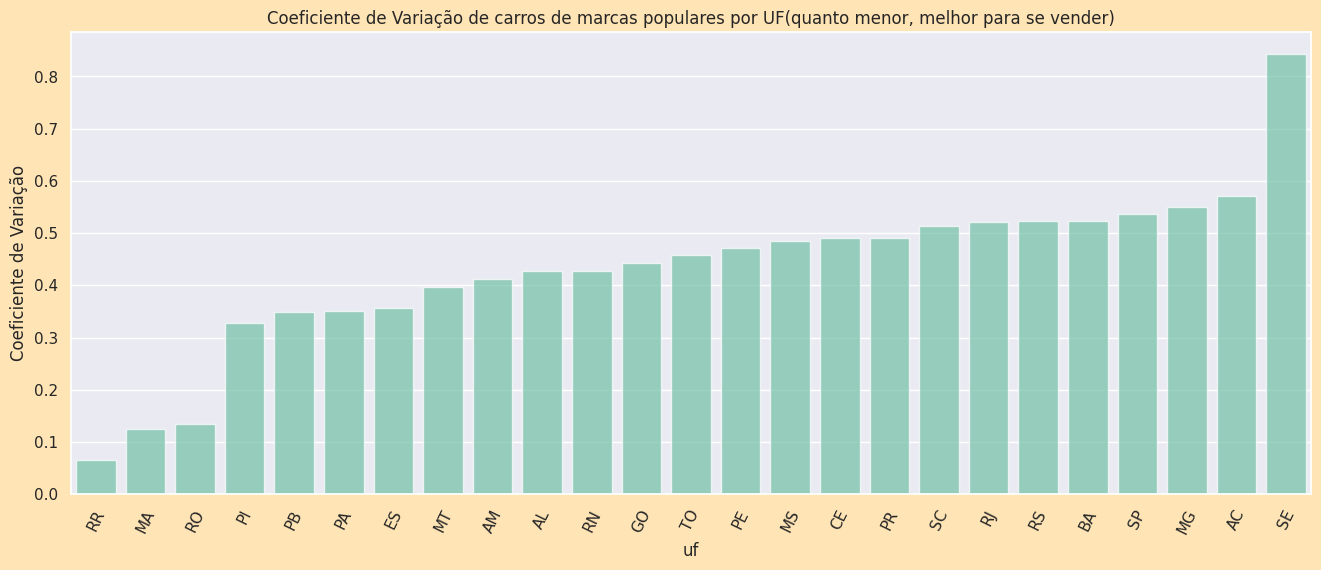

In [19]:
d = marcas_populares.groupby('uf')['preco'].std()
m = marcas_populares.groupby('uf')['preco'].mean()

populares_CV_uf = (d/m).sort_values()
populares_CV_uf

plt.figure(figsize = (16,6), facecolor='moccasin')
sns.barplot(x=populares_CV_uf.index, y=populares_CV_uf, color='mediumaquamarine', alpha=0.7, label='treino');
plt.ylabel('Coeficiente de Variação')
plt.title('Coeficiente de Variação de carros de marcas populares por UF(quanto menor, melhor para se vender)')
plt.xticks(rotation=64)
plt.show()

Curiosamente, Roraima é o estado com menor coeficiente de variação, muito embora tenha a menor média de preços, o que não seria bom sinal. Esta análise puramente numérica com base apenas nos dados que nos foram fornecidos é um indício muito forte de Roraima é o melhor estado para se vender veículos e, se eu for obrigado a dizer qual o melhor lugar para se vender carros de marcas populares, conforme definimos acima, eu digo que o melhor estado é Roraima. 

Entretanto, olhando para a quantidade de veículos de marcas populares anunciados em cada um dos estados, parece difícil decidir entre Maranhão, Piauí, Roraima e Rondonia, pois temos muito poucos dados para querer tomar decisões baseadas apenas em estatística, e em todos esses estados há poucos veículos há vendas do que nós definimos acima como 'marcas populares'. Talvez com um conjunto de dados maior ou uma lista pré-definida de 'marcas populares', pudéssemos ter melhores insights sobre qual o melhor estado.    

In [20]:
marcas_populares['uf'].value_counts()

uf
SP    9931
RJ    1498
PR    1445
SC    1316
MG    1048
RS     863
GO     474
BA     396
PE     218
AL     107
PB      99
RN      73
PA      70
CE      61
AM      47
MT      30
MS      25
ES      20
AC      19
TO      17
SE       8
MA       7
PI       6
RO       4
RR       2
Name: count, dtype: int64

# Picapes com Transmissão Automática
Abaixo, podemos ver que há mais picapes com câmbio automático anunciadas em SP do que em todos as outras UF's combinadas. Isto é um forte indicativo de que SP é o melhor estado na nossa base de dados para comprar uma picape com transmissão automática simplesmente porque lá há mais opções. Mas vamos investigar isso um pouco melhor. 

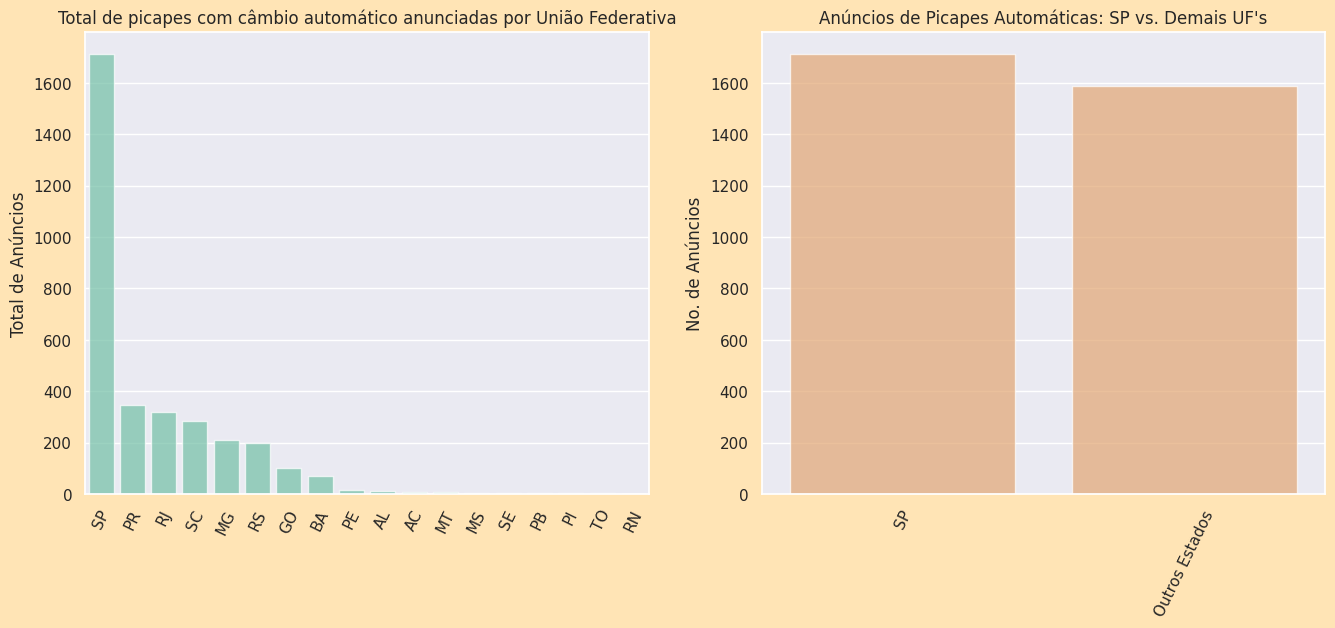

In [21]:
picape_automatica = treino[(treino['tipo'] == 'Picape') & (treino['cambio'] == 'Automática')]
x1 = picape_automatica['uf'].value_counts()

sp = picape_automatica[picape_automatica['uf'] == 'SP'].shape[0]
demais = picape_automatica[picape_automatica['uf'] != 'SP'].shape[0]
data = pd.Series({'SP':sp, 'Outros Estados':demais})

double_bar_plot(x1,
               data,
               figsize = (16,6),
               ylabel1='Total de Anúncios',
               ylabel2="No. de Anúncios",
               title1='Total de picapes com câmbio automático anunciadas por União Federativa',
               title2="Anúncios de Picapes Automáticas: SP vs. Demais UF's",
               color1='mediumaquamarine',
               color2='sandybrown')

Podemos ver (abaixo) que o preço médio de Picapes com transmissão automática de São Paulo não é dos mais altos, mas o desvio padrão é. Quanto mais alto é o desvio padrão, mais os dados estão dispersos. Isso significa que, dos dados que temos em mãos, não só há mais opções em São Paulo do que em todo o resto do país, como também a dispersão dos preços em torno da média só não é maior que a de Santa Catarina, que por sinal possui uma menor média de preço. Quanto maior o desvio padrão, mais temos opções de preços. 

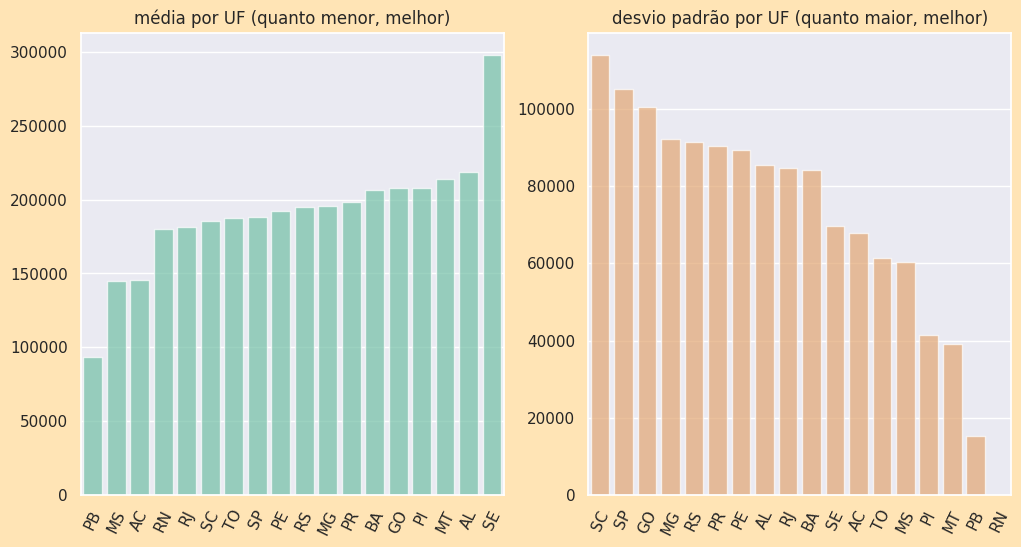

In [22]:
d = picape_automatica.groupby('uf')['preco'].std().sort_values(ascending=False)
m = picape_automatica.groupby('uf')['preco'].mean().sort_values()

double_bar_plot(m,d,
                title1="média por UF (quanto menor, melhor)",
                title2="desvio padrão por UF (quanto maior, melhor)")

Como podemos ver acima, Santa Catarina parece um bom estado para se comprar Picapes Automáticas pois tem uma média de preço menor que a de São Paulo, um Desvio Padrão Maior, e consequentemente, um Coeficiente de Variação Maior. 

Plotamos abaixo a distribuição dos das picapes com transmissão automática no estado de São Paulo e Santa Catarina. Vemos que realmente há muitas opções nas mais diversas faixas de preço. 

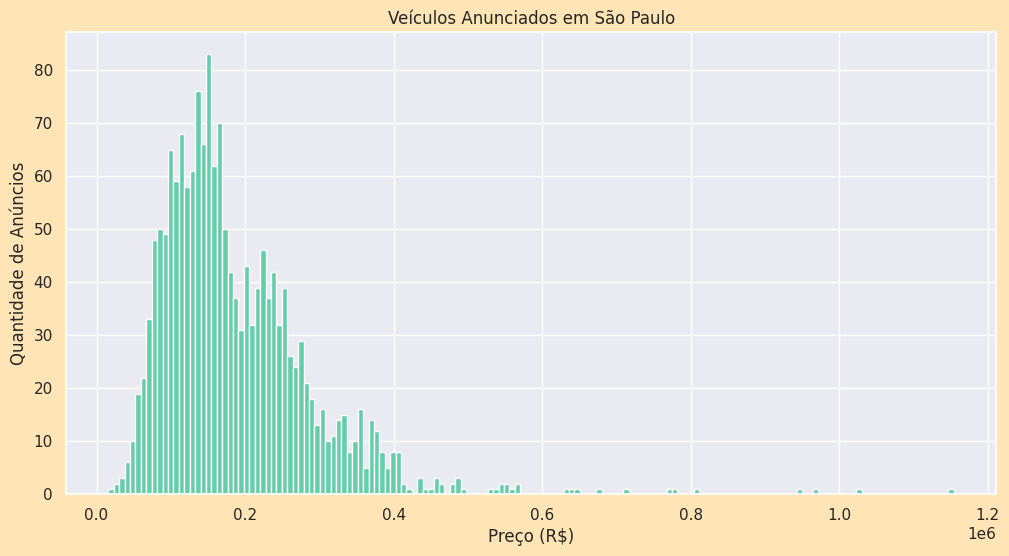

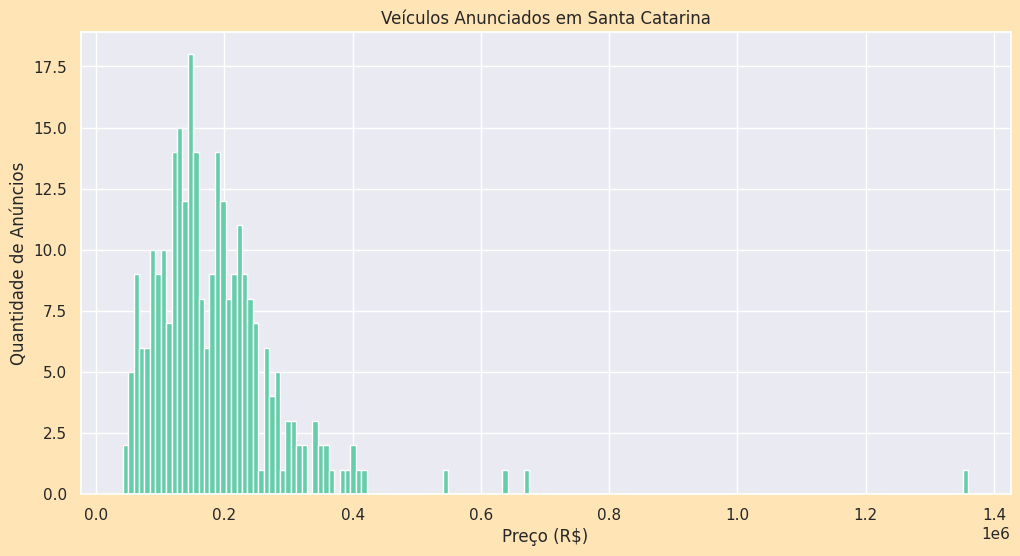

In [23]:
plt.figure(figsize = (12,6), facecolor='moccasin')
# Filtramos veículos acima de R$ 500.000,00 para melhorar a visualização.
# Há veículos com preços acima disso, mas não chegariam a ser visíveis neste gráfico  
plt.hist(picape_automatica[(picape_automatica['uf'] == 'SP')]['preco'], bins=156, color='mediumaquamarine');
plt.xlabel("Preço (R$)")
plt.ylabel("Quantidade de Anúncios")
plt.title("Veículos Anunciados em São Paulo")
plt.show()

plt.figure(figsize = (12,6), facecolor='moccasin')
# Filtramos veículos acima de R$ 500.000,00 para melhorar a visualização.
# Há veículos com preços acima disso, mas não chegariam a ser visíveis neste gráfico  
plt.hist(picape_automatica[(picape_automatica['uf'] == 'SC')]['preco'], bins=156, color='mediumaquamarine');
plt.xlabel("Preço (R$)");
plt.ylabel("Quantidade de Anúncios")
plt.title("Veículos Anunciados em Santa Catarina");
plt.show()

Vamos agora olhar para o Coeficiente de Variação, dessa vez procurando o maior:

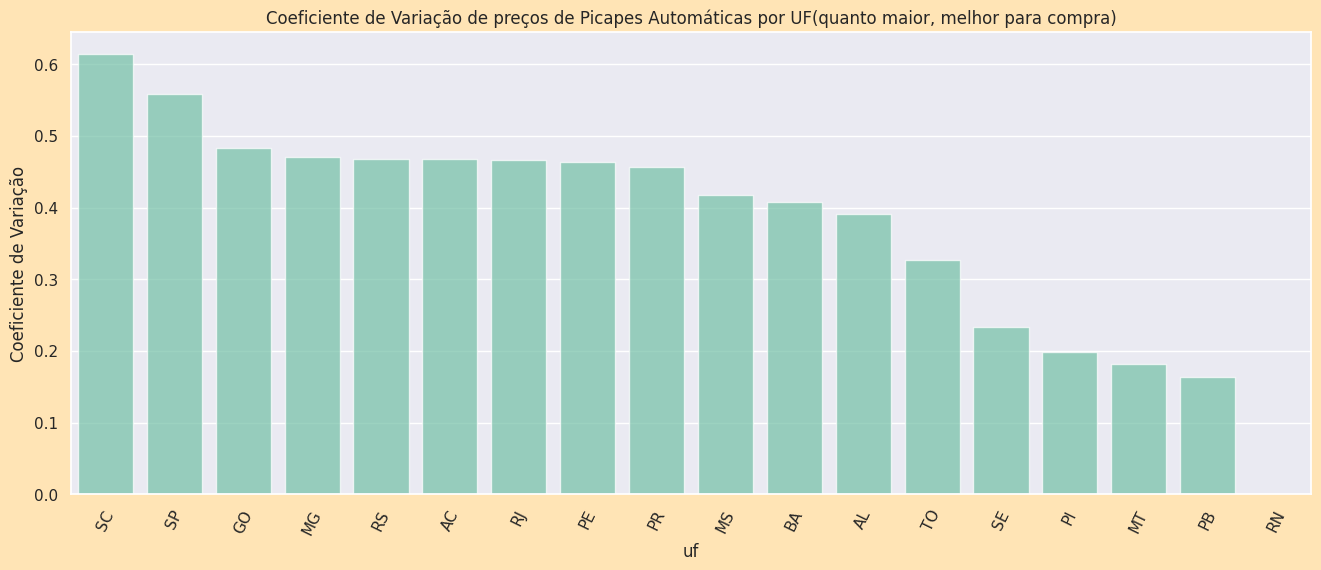

In [24]:
d = picape_automatica.groupby('uf')['preco'].std()
m = picape_automatica.groupby('uf')['preco'].mean()

picape_automatica_CV_uf = (d/m).sort_values(ascending=False)

plt.figure(figsize = (16,6), facecolor='moccasin')
sns.barplot(x=picape_automatica_CV_uf.index, y=picape_automatica_CV_uf, color='mediumaquamarine', alpha=0.7, label='treino');
plt.ylabel('Coeficiente de Variação')
plt.title('Coeficiente de Variação de preços de Picapes Automáticas por UF(quanto maior, melhor para compra)')
plt.xticks(rotation=64)
plt.show()

Santa Catarina tem um Coeficiente de Variação maior, o que já era esperado, dado que a média de preços em SC é meor que em SP e que o desvio padrão é maior em SC. Mas isso não é conclusivo, primeiro porque há muito mais opções em São Paulo do que em Santa Catarina, e segundo porque temos a disposição mais dados para analisar. Vamos olhar para fatores qualitativos agora: 

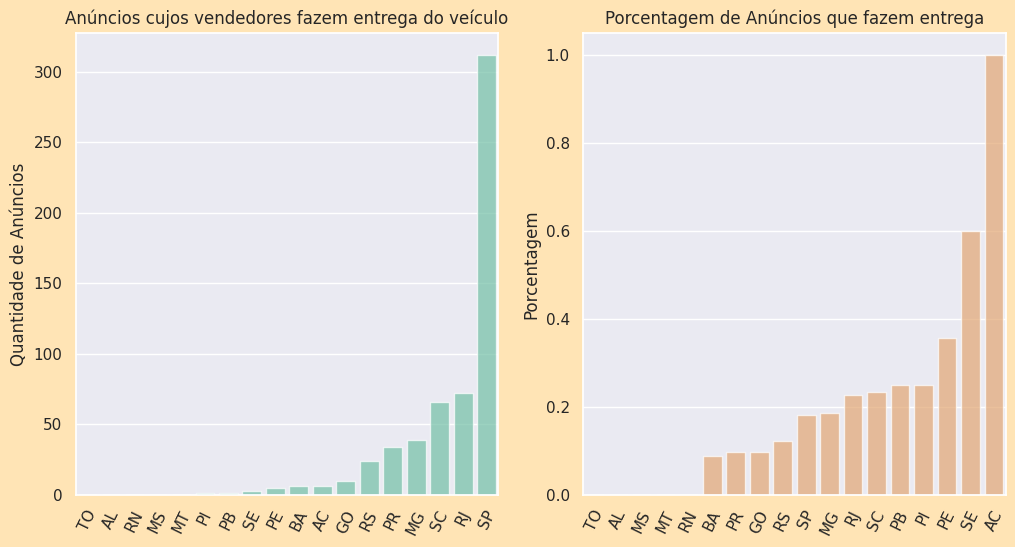

In [25]:
delivery = picape_automatica.groupby('uf')['delivery'].sum()
delivery_pct = picape_automatica.groupby('uf')['delivery'].sum()/picape_automatica['uf'].value_counts()
delivery.sort_values(inplace=True)
delivery_pct.sort_values(inplace=True)

double_bar_plot(series1=delivery,
               series2=delivery_pct,
               ylabel1='Quantidade de Anúncios',
               ylabel2='Porcentagem',
               title1='Anúncios cujos vendedores fazem entrega do veículo',
               title2='Porcentagem de Anúncios que fazem entrega'
               )               

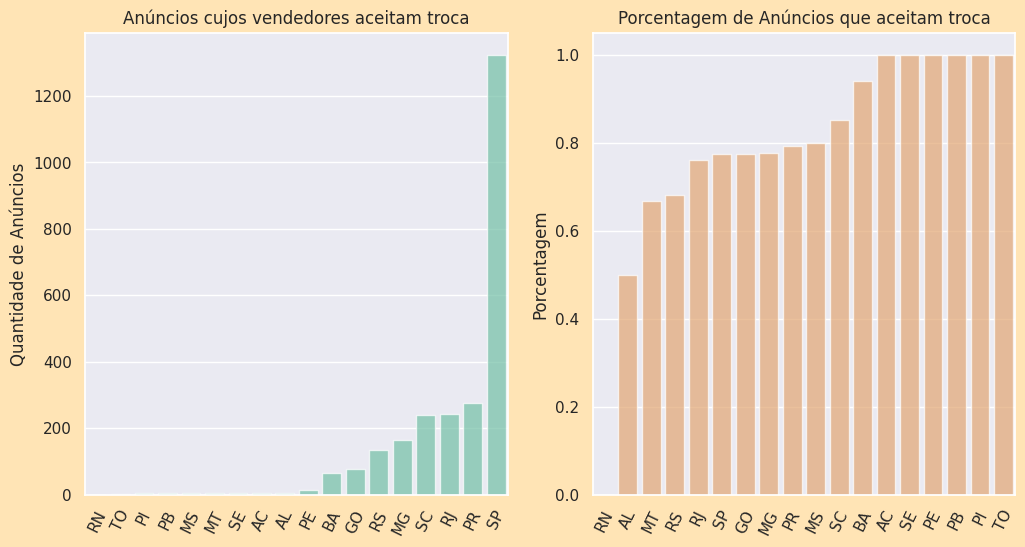

In [26]:
aceita_troca = picape_automatica.groupby('uf')['aceita_troca'].sum()
aceita_troca_pct = picape_automatica.groupby('uf')['aceita_troca'].sum()/picape_automatica['uf'].value_counts()

aceita_troca.sort_values(inplace=True)
aceita_troca_pct.sort_values(inplace=True)

double_bar_plot(aceita_troca,
                    aceita_troca_pct,
                    ylabel1='Quantidade de Anúncios',
                    ylabel2='Porcentagem',
                    title1='Anúncios cujos vendedores aceitam troca',
                    title2='Porcentagem de Anúncios que aceitam troca',
                   color1='mediumaquamarine',
                   color2='sandybrown')

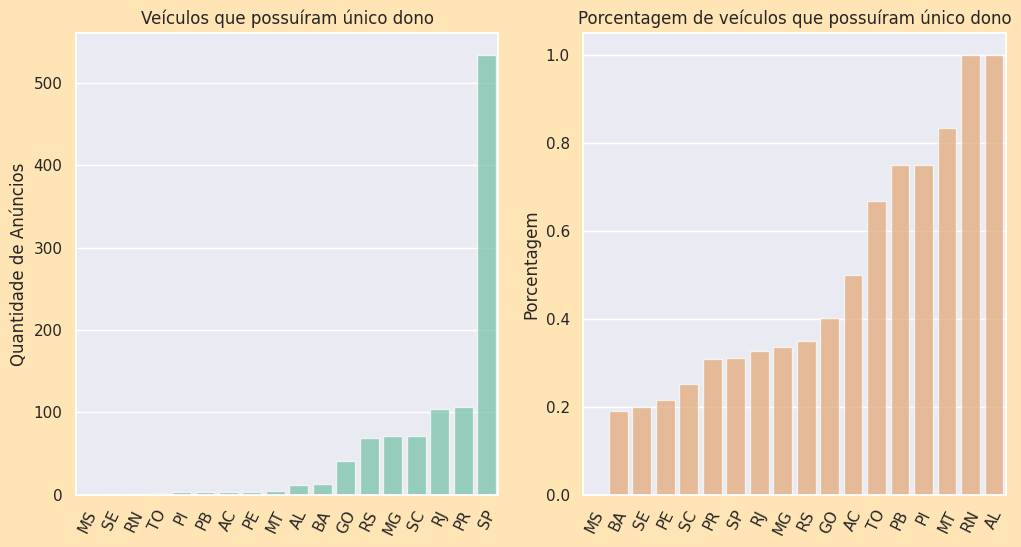

In [27]:
unico_dono = picape_automatica.groupby('uf')['unico_dono'].sum()
unico_dono_pct = picape_automatica.groupby('uf')['unico_dono'].sum()/picape_automatica['uf'].value_counts()

unico_dono.sort_values(inplace=True)
unico_dono_pct.sort_values(inplace=True)

double_bar_plot(unico_dono,
                    unico_dono_pct,
                    ylabel1='Quantidade de Anúncios',
                    ylabel2='Porcentagem',
                    title1='Veículos que possuíram único dono',
                    title2='Porcentagem de veículos que possuíram único dono')

Em um caso real, seguiríamos explorando as demais características do veículo. Aqui, por questões de tempo e também para poupar o leitor, concluíremos que São Paulo é o melhor estado para se comprar Picapes Automáticas porque há uma média baixa de preços, há muito mais anúncios do que em todo o resto do país combinados, há mais opções que fazem entrega do veículo, há mais anúncios de veículos que possuíram único dono, há mais anúncios cujo vendedor aceita troca... 
Talvez um último fator seja ainda relevante de ser checado: a quantidade de marcas disponíveis para a compra. Abaixo, vemos que São Paulo também oferece mais opções de marcas para se comprar. 

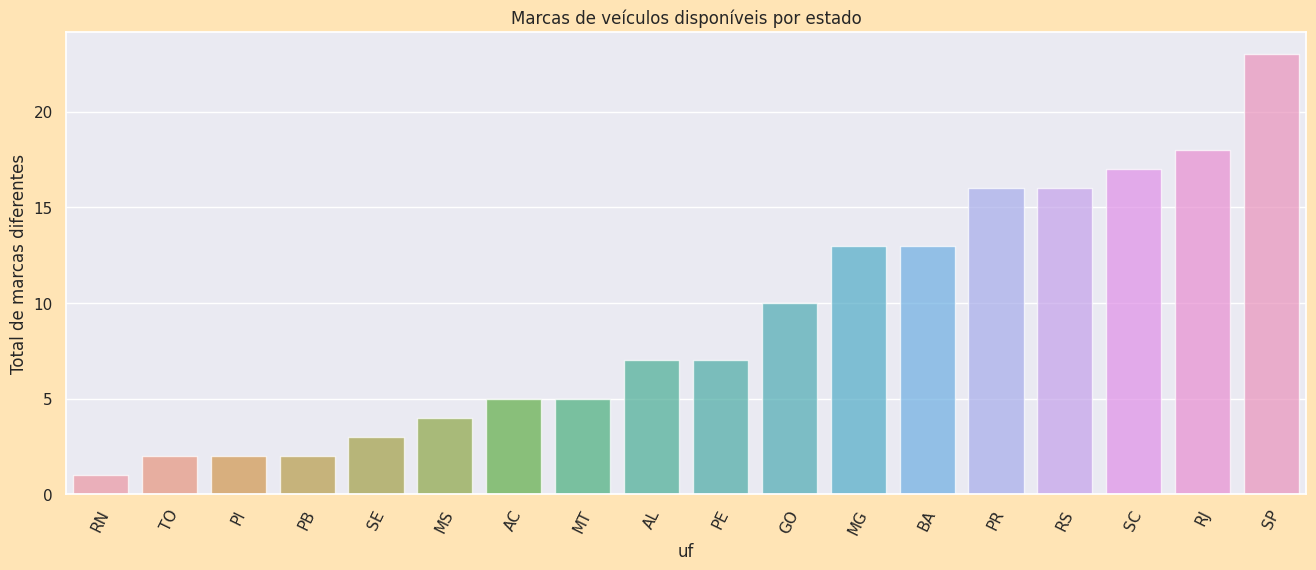

In [28]:
marcas = picape_automatica.groupby('uf')['marca'].nunique()
marcas.sort_values(inplace=True)

plt.figure(figsize=(16,6), facecolor='moccasin')
sns.barplot(x=marcas.index, y=marcas, alpha=0.7);
plt.ylabel("Total de marcas diferentes")
plt.title("Marcas de veículos disponíveis por estado")
plt.xticks(rotation=64)
plt.show()

# Carros que ainda estão dentro da garantia de fábrica
A análise aqui é análoga à análise feita anteriormente, por isso seremos um pouco mais diretos aqui. Também cabe observar que a discrepância da quantidade de anúncios de SP para o resto do país em nossa base de dados é tão grande que o problema é quase trivial. 

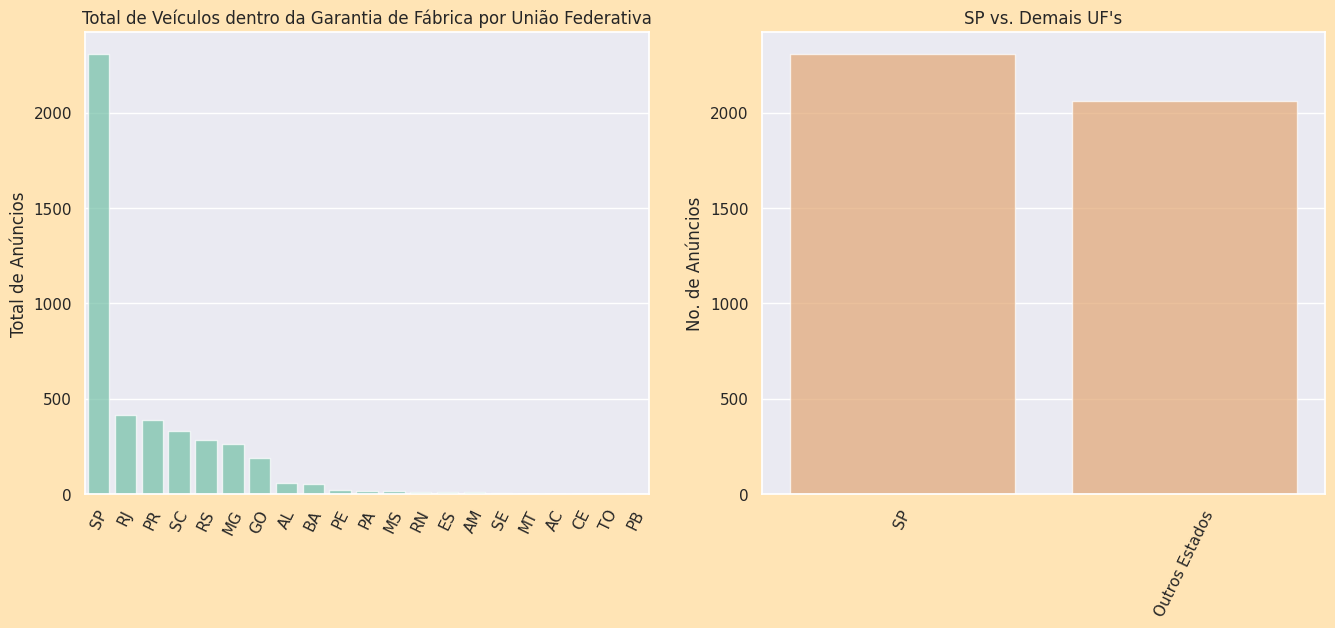

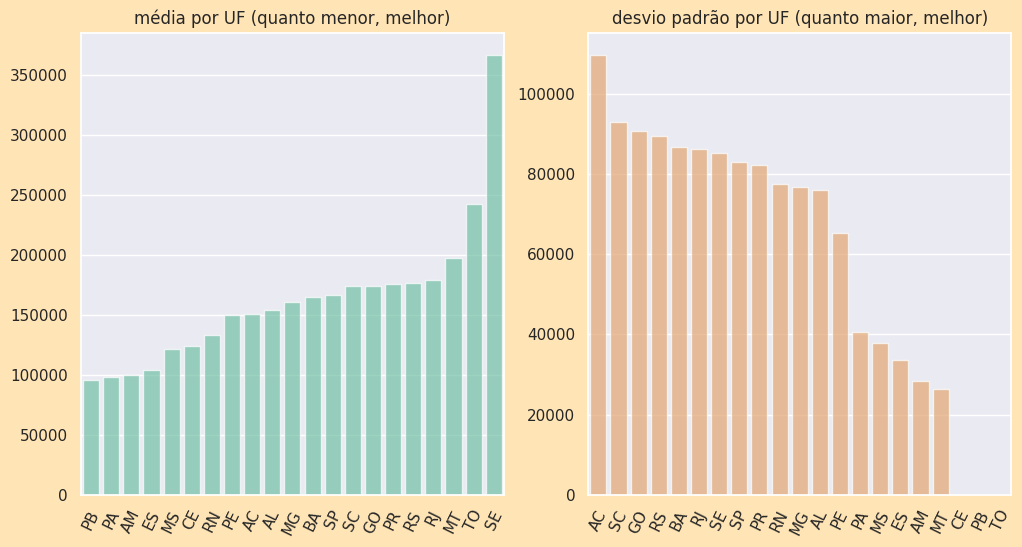

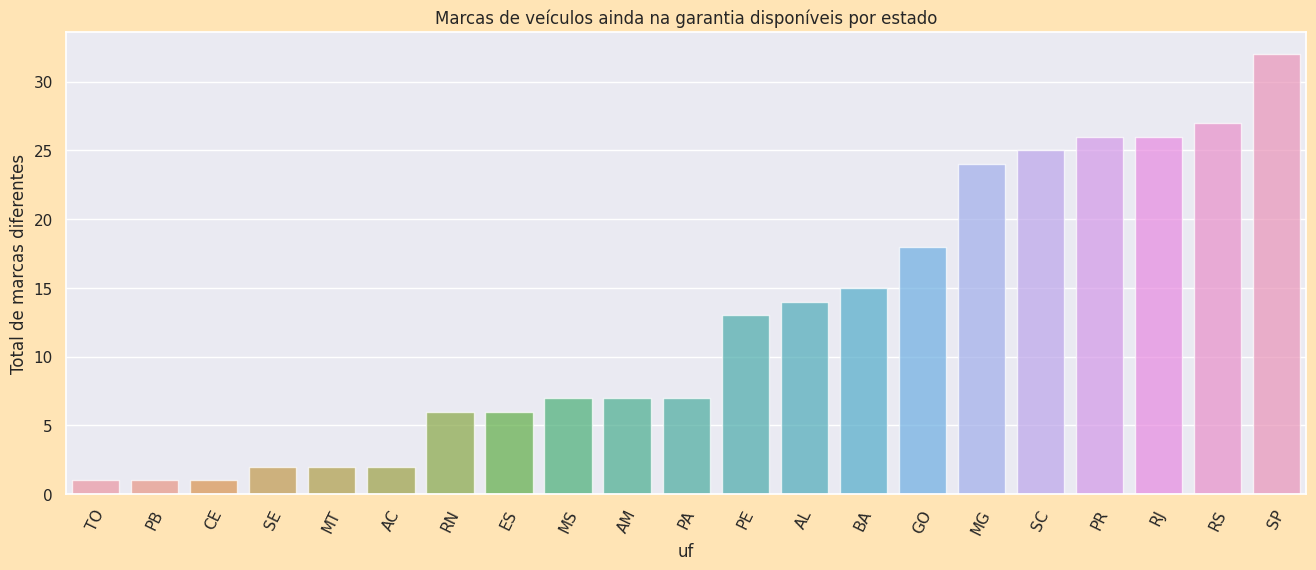

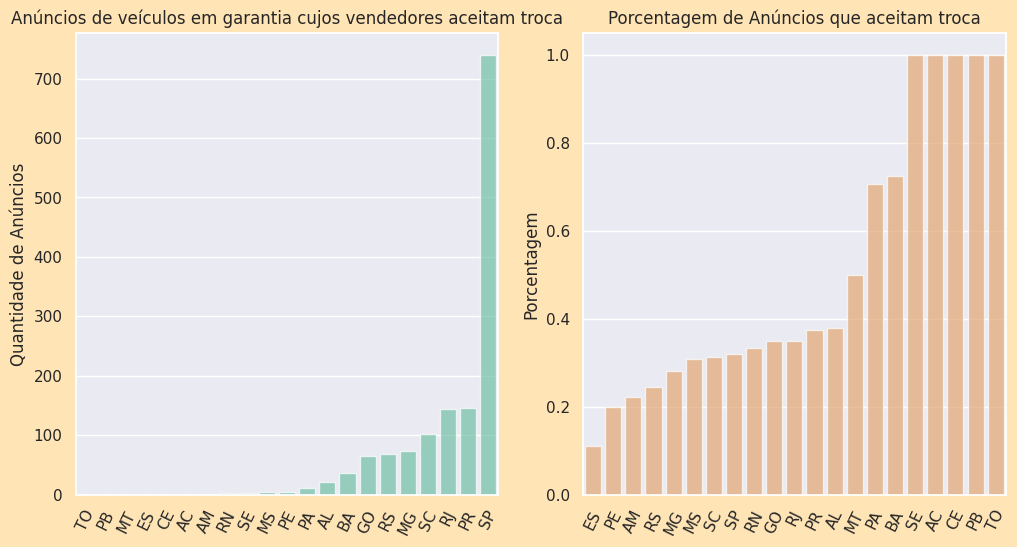

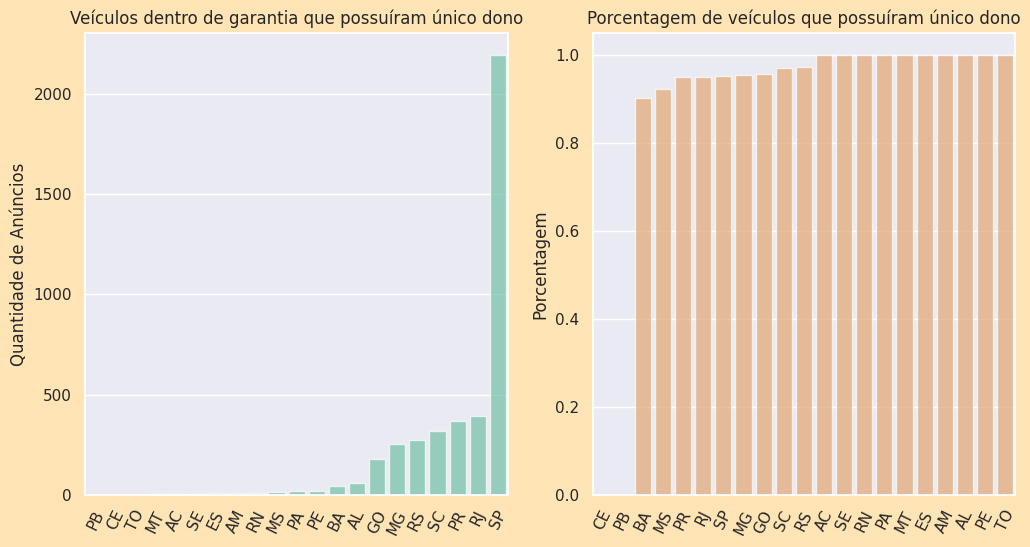

In [29]:
garantia = treino[(treino['garantia'] == True)]
x1 = garantia['uf'].value_counts()

sp = garantia[garantia['uf'] == 'SP'].shape[0]
demais = garantia[garantia['uf'] != 'SP'].shape[0]
data = pd.Series({'SP':sp, 'Outros Estados':demais})

double_bar_plot(x1,
               data,
               figsize = (16,6),
               ylabel1='Total de Anúncios',
               ylabel2="No. de Anúncios",
               title1='Total de Veículos dentro da Garantia de Fábrica por União Federativa',
               title2="SP vs. Demais UF's",
               color1='mediumaquamarine',
               color2='sandybrown')

d = garantia.groupby('uf')['preco'].std().sort_values(ascending=False)
m = garantia.groupby('uf')['preco'].mean().sort_values()

double_bar_plot(m,d,
                title1="média por UF (quanto menor, melhor)",
                title2="desvio padrão por UF (quanto maior, melhor)")

marcas = garantia.groupby('uf')['marca'].nunique()
marcas.sort_values(inplace=True)

plt.figure(figsize=(16,6), facecolor='moccasin')
sns.barplot(x=marcas.index, y=marcas, alpha=0.7);
plt.ylabel("Total de marcas diferentes")
plt.title("Marcas de veículos ainda na garantia disponíveis por estado")
plt.xticks(rotation=64)
plt.show()


aceita_troca = garantia.groupby('uf')['aceita_troca'].sum()
aceita_troca_pct = garantia.groupby('uf')['aceita_troca'].sum()/garantia['uf'].value_counts()

aceita_troca.sort_values(inplace=True)
aceita_troca_pct.sort_values(inplace=True)

double_bar_plot(aceita_troca,
                    aceita_troca_pct,
                    ylabel1='Quantidade de Anúncios',
                    ylabel2='Porcentagem',
                    title1='Anúncios de veículos em garantia cujos vendedores aceitam troca',
                    title2='Porcentagem de Anúncios que aceitam troca',
                   color1='mediumaquamarine',
                   color2='sandybrown')


unico_dono = garantia.groupby('uf')['unico_dono'].sum()
unico_dono_pct = garantia.groupby('uf')['unico_dono'].sum()/garantia['uf'].value_counts()

unico_dono.sort_values(inplace=True)
unico_dono_pct.sort_values(inplace=True)

double_bar_plot(unico_dono,
                    unico_dono_pct,
                    ylabel1='Quantidade de Anúncios',
                    ylabel2='Porcentagem',
                    title1='Veículos dentro de garantia que possuíram único dono',
                    title2='Porcentagem de veículos que possuíram único dono')

Os gráficos acima sugerem que São Paulo também é o melhor lugar para se comprar veículos ainda em garantia de fábrica por haver maior disponibilidade de marcas, mais veículos ainda em garantia que possuíram único dono, cujo dono aceita troca, etc. 

# Regressão
Temos aqui um problema de regressão, e não de classificação, já que queremos prever uma variável (preço) que pode assumir, a princípio, qualquer valor positivo. Faremos aqui uma regressão linear. Começamos preparando o conjunto que temos para treino: 

In [30]:
X = pd.get_dummies(treino.drop('preco', axis=1))
y = treino['preco']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Agora, criamos e treinamos o modelo de regressão linear: 

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

Por fim, fazemos as previsões e avaliamos a performance do modelo:

In [ ]:
y_pred = model.predict(X_train)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)